In [1]:
# Getting the dataset

import pandas as pd
train=pd.read_csv("C:/Users/DELL/Downloads/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Extracting data of all the Carters

current_passenger=train[train["PassengerId"].eq(250)]
last_name=current_passenger.Name.to_string(index=False).split(',')[0]
train[train["Name"].str.contains(last_name)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0,NaN,S


In [3]:
# Defining the Carters to be a new dataset

ticket=current_passenger["Ticket"].to_string(index=False)
passengerId=current_passenger["PassengerId"]

group=train[train["PassengerId"].ne(passengerId) & (train["Name"].str.contains(last_name) | train["Ticket"].eq(ticket))]

print(group)

     PassengerId  Survived  Pclass  \
390          391         1       1   
435          436         1       1   
763          764         1       1   
802          803         1       1   
854          855         0       2   

                                              Name     Sex   Age  SibSp  \
390                     Carter, Mr. William Ernest    male  36.0      1   
435                      Carter, Miss. Lucile Polk  female  14.0      1   
763      Carter, Mrs. William Ernest (Lucile Polk)  female  36.0      1   
802            Carter, Master. William Thornton II    male  11.0      1   
854  Carter, Mrs. Ernest Courtenay (Lilian Hughes)  female  44.0      1   

     Parch  Ticket   Fare    Cabin Embarked  
390      2  113760  120.0  B96 B98        S  
435      2  113760  120.0  B96 B98        S  
763      2  113760  120.0  B96 B98        S  
802      2  113760  120.0  B96 B98        S  
854      0  244252   26.0      NaN        S  


In [4]:
# Encoding our passengers 

QUBITS=3

def encode(pos):
    bpos="{:0{}b}".format(pos, QUBITS)
    return bpos

number_of_rows=len(group.index)
for pos in range(0, 2**QUBITS):
    if pos>=number_of_rows:
        break
        
    passenger=group.iloc[[pos]]
    print(pos, encode(pos), passenger.Name.to_string(index=False))

0 000 Carter, Mr. William Ernest
1 001 Carter, Miss. Lucile Polk
2 010 Carter, Mrs. William Ernest (Lucile Polk)
3 011 Carter, Master. William Thornton II
4 100 Carter, Mrs. Ernest Courtenay (Lilian Hughes)


In [5]:
# Creating uniform superposition of the states

from qiskit import QuantumRegister, QuantumCircuit

RULES=2

q_pass=QuantumRegister(QUBITS, name='passenger')
q_rules=QuantumRegister(RULES, name='rules')

qc=QuantumCircuit(q_pass, q_rules)

qc.h(q_pass)
qc.barrier()

qc.draw()

┌───┐ ░ 
passenger_0: ┤ H ├─░─
             ├───┤ ░ 
passenger_1: ┤ H ├─░─
             ├───┤ ░ 
passenger_2: ┤ H ├─░─
             └───┘ ░ 
    rules_0: ──────░─
                   ░ 
    rules_1: ──────░─
                   ░

In [6]:
# Defining our oracle

def oracle(passenger, group, q_p, q_r, draw=False):
    o_qc=QuantumCircuit(q_p, q_r)
    
    for pos in range(0, 2**QUBITS):
        if pos>=len(group.index):
            break
            
        bpos=encode(pos)
        
        select_state(bpos, o_qc, q_p)
        
        apply_rules(passenger, group.iloc[[pos]], o_qc, q_p, q_r)
        
        select_state(bpos, o_qc, q_p)
        
        if draw:
            o_qc.barrier()
            
    if draw:
        return o_qc.draw()
    
    else:
        Oracle=o_qc.to_gate()
        Oracle.name="oracle"
        return Oracle

In [7]:
# Defining a function to select/unselect the states to mark their amplitudes

def select_state(bpos, qc, qubits):
    for i in range(0, QUBITS):
        if bpos[::-1][i]=="0":
            qc.x(qubits[i])

In [8]:
# Defining the rules

from qiskit.circuit.library import ZGate

def apply_rules(passenger, current, qc, q_p, q_r):
    
    if passenger.Ticket.to_string(index=False)==current.Ticket.to_string(index=False):
        qc.mcx(q_p, q_r[0])
        
    if passenger.Name.to_string(index=False).split(',')[0]==current.Name.to_string(index=False).split(',')[0]:
        qc.mcx(q_p, q_r[1])
        
    qc.append(ZGate().control(QUBITS+RULES-1), [*q_p, *q_r])

    if passenger.Name.to_string(index=False).split(',')[0]==current.Name.to_string(index=False).split(',')[0]:
        qc.mcx(q_p, q_r[1])    
    
    if passenger.Ticket.to_string(index=False)==current.Ticket.to_string(index=False):
        qc.mcx(q_p, q_r[0])

In [9]:
# Final structure of the Oracle

oracle(current_passenger, group, q_pass, q_rules, True)

┌───┐             ┌───┐ ░                         ░ ┌───┐        »
passenger_0: ┤ X ├──■───■───■──┤ X ├─░────────■───■───■────────░─┤ X ├──■───■─»
             ├───┤  │   │   │  ├───┤ ░ ┌───┐  │   │   │  ┌───┐ ░ └───┘  │   │ »
passenger_1: ┤ X ├──■───■───■──┤ X ├─░─┤ X ├──■───■───■──┤ X ├─░────────■───■─»
             ├───┤  │   │   │  ├───┤ ░ ├───┤  │   │   │  ├───┤ ░ ┌───┐  │   │ »
passenger_2: ┤ X ├──■───■───■──┤ X ├─░─┤ X ├──■───■───■──┤ X ├─░─┤ X ├──■───■─»
             └───┘  │   │   │  └───┘ ░ └───┘  │   │   │  └───┘ ░ └───┘  │   │ »
    rules_0: ───────┼───■───┼────────░────────┼───■───┼────────░────────┼───■─»
                  ┌─┴─┐ │ ┌─┴─┐      ░      ┌─┴─┐ │ ┌─┴─┐      ░      ┌─┴─┐ │ »
    rules_1: ─────┤ X ├─■─┤ X ├──────░──────┤ X ├─■─┤ X ├──────░──────┤ X ├─■─»
                  └───┘   └───┘      ░      └───┘   └───┘      ░      └───┘   »
«                  ┌───┐ ░                         ░ ┌───┐                  »
«passenger_0: ──■──┤ X ├─░────────■───■───■────────░─┤ X ├──■────■───■───■──»
«               │  └───┘ ░        │   │   │        ░ ├───┤  │    │   │   │  »
«passenger_1: ──■────────░────────■───■───■────────░─┤ X ├──■────■───■───■──»
«               │  ┌───┐ ░ ┌───┐  │   │   │  ┌───┐ ░ └───┘  │    │   │   │  »
«passenger_2: ──■──┤ X ├─░─┤ X ├──■───■───■──┤ X ├─░────────■────■───■───■──»
«               │  └───┘ ░ └───┘  │   │   │  └───┘ ░      ┌─┴─┐  │   │   │  »
«    rules_0: ──┼────────░────────┼───■───┼────────░──────┤ X ├──┼───■───┼──»
«             ┌─┴─┐      ░      ┌─┴─┐ │ ┌─┴─┐      ░      └───┘┌─┴─┐ │ ┌─┴─┐»
«    rules_1: ┤ X ├──────░──────┤ X ├─■─┤ X ├──────░───────────┤ X ├─■─┤ X ├»
«             └───┘      ░      └───┘   └───┘      ░           └───┘   └───┘»
«                  ┌───┐ ░ 
«passenger_0: ──■──┤ X ├─░─
«               │  ├───┤ ░ 
«passenger_1: ──■──┤ X ├─░─
«               │  └───┘ ░ 
«passenger_2: ──■────────░─
«             ┌─┴─┐      ░ 
«    rules_0: ┤ X ├──────░─
«             └───┘      ░ 
«    rules_1: ───────────░─
«                        ░

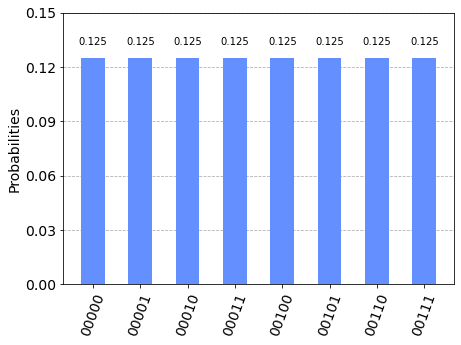

In [10]:
# Initial probabilities of measurement 

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

results = execute(qc,Aer.get_backend('statevector_simulator')).result()
plot_histogram(results.get_counts())

In [11]:
# Defining the Amplifier

def amplifier(passenger, q_p, draw=False):
    
    a_qc=QuantumCircuit(q_p)
    
    a_qc.h(q_p)
    a_qc.x(q_p)
    a_qc.append(ZGate().control(QUBITS-1), q_p)
    a_qc.x(q_p)
    a_qc.h(q_p)
    
    if draw:
        return a_qc.draw()
    else:
        Amplifier=a_qc.to_gate()
        Amplifier.name="amplifier"
        return Amplifier

In [12]:
# Structure of the Amplifier

amplifier(current_passenger, q_pass, draw=True)

┌───┐┌───┐   ┌───┐┌───┐
passenger_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
             ├───┤├───┤ │ ├───┤├───┤
passenger_1: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
             ├───┤├───┤ │ ├───┤├───┤
passenger_2: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
             └───┘└───┘   └───┘└───┘

In [13]:
# The compound operator as an Oracle-Amplifier combination

qc=QuantumCircuit(q_pass, q_rules)

qc.h(q_pass)

qc.append(oracle(current_passenger, group, q_pass, q_rules), [*q_pass, *q_rules])

qc.append(amplifier(current_passenger, q_pass), q_pass)

qc.draw()

┌───┐┌─────────┐┌────────────┐
passenger_0: ┤ H ├┤0        ├┤0           ├
             ├───┤│         ││            │
passenger_1: ┤ H ├┤1        ├┤1 amplifier ├
             ├───┤│         ││            │
passenger_2: ┤ H ├┤2 oracle ├┤2           ├
             └───┘│         │└────────────┘
    rules_0: ─────┤3        ├──────────────
                  │         │              
    rules_1: ─────┤4        ├──────────────
                  └─────────┘

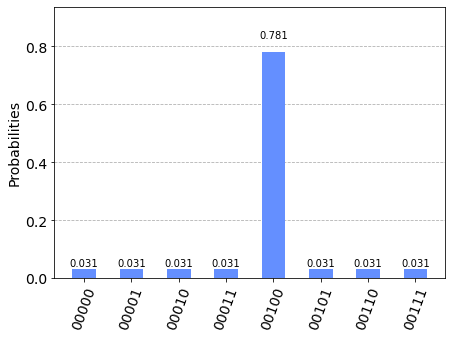

In [14]:
# Probabilities after amplification

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

results = execute(qc,Aer.get_backend('statevector_simulator')).result()
plot_histogram(results.get_counts())

In [15]:
# Estimating the optimal number of iterations 

def rounds(number_of_rounds, qc, current_passenger, group, q_pass, q_rules):
    print("{} iterations".format(number_of_rounds))
    
    for i in range(0, round(number_of_rounds)):
        qc.append(oracle(current_passenger, group, q_pass, q_rules), [*q_pass, *q_rules])
        qc.append(amplifier(current_passenger, q_pass), q_pass)

In [16]:
# Finalized circuit

from math import pi, sqrt
qc=QuantumCircuit(q_pass, q_rules)

qc.h(q_pass)
rounds(pi*sqrt(2**QUBITS)/4, qc, current_passenger, group, q_pass, q_rules)
qc.draw()

2.221441469079183 iterations


┌───┐┌─────────┐┌────────────┐┌─────────┐┌────────────┐
passenger_0: ┤ H ├┤0        ├┤0           ├┤0        ├┤0           ├
             ├───┤│         ││            ││         ││            │
passenger_1: ┤ H ├┤1        ├┤1 amplifier ├┤1        ├┤1 amplifier ├
             ├───┤│         ││            ││         ││            │
passenger_2: ┤ H ├┤2 oracle ├┤2           ├┤2 oracle ├┤2           ├
             └───┘│         │└────────────┘│         │└────────────┘
    rules_0: ─────┤3        ├──────────────┤3        ├──────────────
                  │         │              │         │              
    rules_1: ─────┤4        ├──────────────┤4        ├──────────────
                  └─────────┘              └─────────┘

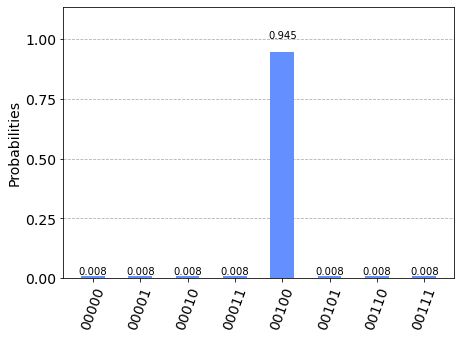

In [17]:
# Maximized probability 

results=execute(qc, Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)